latitude      1653
longitude     1653
brightness    1653
scan          1653
track         1653
acq_date      1653
acq_time      1653
satellite     1653
instrument    1653
confidence    1653
version       1653
bright_t31    1653
frp           1653
daynight      1653
dtype: int64


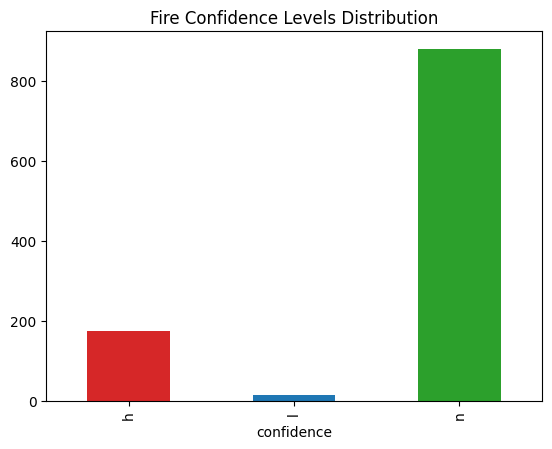

In [6]:
import pandas as pd
import folium

# Import data wildfire
df = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")


# Filter untuk wilayah Los Angeles
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2

df = df[
    (df['latitude'] >= lat_min) &
    (df['latitude'] <= lat_max) &
    (df['longitude'] >= lon_min) &
    (df['longitude'] <= lon_max)
]

# Convert acq_date dan acq_time
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['acq_time'] = df['acq_time'].astype(str)
df['date_time'] = pd.to_datetime(df['acq_date'].dt.strftime('%Y-%m-%d') + ' ' + df['acq_time'].str.zfill(4).str[:2] + ':' + df['acq_time'].str.zfill(4).str[2:])

# Sort data berdasarkan waktu
sorted_df = df.sort_values('date_time', ascending=True)

# Filter berdasarkan tanggal
based_date = df[df['acq_date'] == pd.Timestamp(2025, 1, 8)]

# Group by confidence dan hitung jumlah
confidences = based_date.groupby('confidence').agg(value_count=('confidence', 'count')).reset_index()

# Plot grafik batang (optional)
bar_labels = ['high', 'normal', 'low']
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax = confidences.plot(
    x='confidence',
    y='value_count',
    kind='bar',
    title='Fire Confidence Levels Distribution',
    color=bar_colors,
    legend=False
)

# Map Los Angeles
map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Loop untuk menambahkan CircleMarker
for index, row in based_date.iterrows():
    if row['confidence'] == 'h':
        color = 'red'
    elif row['confidence'] == 'n':
        color = 'blue'
    else:
        color = 'green'

    # Menambahkan marker ke peta
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Confidence: {row['confidence']}<br>Date: {row['date_time']}"
    ).add_to(map)

# Simpan peta sebagai HTML
map.save('wildfire_map.html')
map


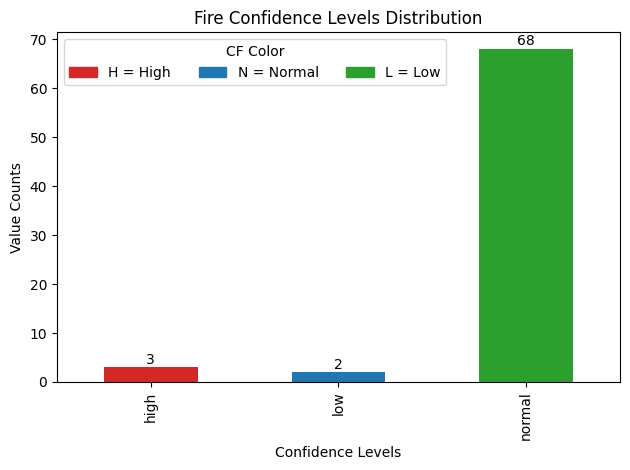

In [156]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point

# Import data wildfire
df = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")

# Filter lokasi (Los Angeles)
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
df = df[
    (df['latitude'] >= lat_min) &
    (df['latitude'] <= lat_max) &
    (df['longitude'] >= lon_min) &
    (df['longitude'] <= lon_max)
]

# Konversi tanggal dan waktu
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['acq_time'] = df['acq_time'].astype(str)
df['date_time'] = pd.to_datetime(
    df['acq_date'].dt.strftime('%Y-%m-%d') + ' ' +
    df['acq_time'].str.zfill(4).str[:2] + ':' + df['acq_time'].str.zfill(4).str[2:]
)
sorted_df = df.sort_values('date_time', ascending=True)

# Filter data berdasarkan tanggal tertentu
based_date = df[df['acq_date'] == pd.Timestamp(2025, 1, 10)]


# Group by confidence dan hitung jumlah
confidences = based_date.groupby('confidence').agg(value_count=('confidence', 'count')).reset_index()

# Urutkan confidence berdasarkan kategori logis
confidence_order = {'h': 'high', 'n': 'normal', 'l': 'low'}
confidences['confidence_label'] = confidences['confidence'].map(confidence_order)
confidences = confidences.sort_values('confidence_label')

# Plot grafik batang
bar_colors = ['tab:red', 'tab:blue', 'tab:green']
ax = confidences.plot(
    x='confidence_label',
    y='value_count',
    kind='bar',
    color=bar_colors,
    legend=False,
    title='Fire Confidence Levels Distribution'
)

# Tambahkan angka di atas batang
for i, value in enumerate(confidences['value_count']):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Atur sumbu dan label
ax.set_ylabel('Value Counts')
ax.set_xlabel('Confidence Levels')

# Buat handle warna manual untuk legenda
custom_handles = [
    mpatches.Patch(color='tab:red', label='H = High'),
    mpatches.Patch(color='tab:blue', label='N = Normal'),
    mpatches.Patch(color='tab:green', label='L = Low')
]

# Tambahkan legenda ke grafik
ax.legend(handles=custom_handles, title='CF Color', loc='upper left', bbox_to_anchor=(0, 1), ncol=3)

# Tampilkan grafik
plt.tight_layout()
plt.show()





Index(['OBJECTID', 'name', 'geometry'], dtype='object')


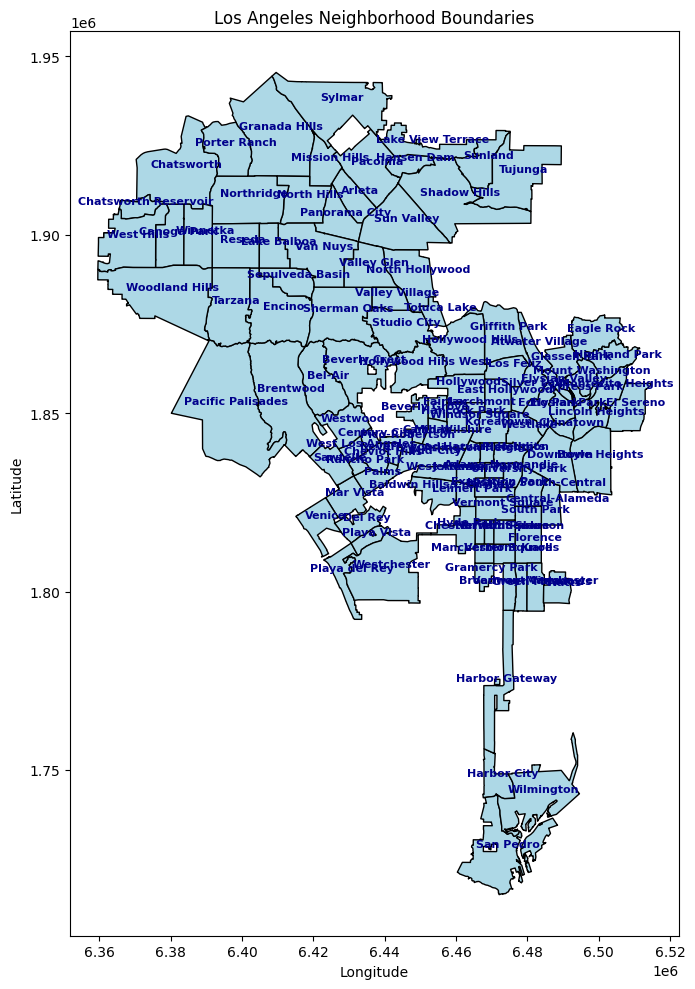

In [222]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Baca file shapefile Los Angeles neighborhoods
shapefile_path = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"

# Baca data shapefile ke GeoDataFrame
neighborhoods_gdf = gpd.read_file(shapefile_path)
print(neighborhoods_gdf.columns)

# Tampilkan semua wilayah/neighborhood di Los Angeles
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods_gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# Tambahkan nama setiap wilayah di dalam polygon
for idx, row in neighborhoods_gdf.iterrows():
    # Mendapatkan pusat geometri (centroid) setiap polygon
    centroid = row['geometry'].centroid
    # Menambahkan teks di koordinat pusat centroid
    ax.annotate(
        row['name'],  # Nama wilayah
        xy=(centroid.x, centroid.y),  # Koordinat centroid
        xytext=(5, 5),  # Offset teks
        textcoords='offset points',  # Menggunakan offset dalam poin
        fontsize=8,  # Ukuran font
        color='darkblue',  # Warna teks
        fontweight='bold',  # Tebalkan font
        ha='center',  # Horizontal alignment
        va='center'  # Vertical alignment
    )

# Tambahkan judul dan atur tampilan grafik
plt.title('Los Angeles Neighborhood Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Tampilkan grafik
plt.show()


In [357]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from concurrent.futures import ThreadPoolExecutor
import pickle
import os

# Import data wildfire
df = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")

# Konversi tanggal dan waktu
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Filter hanya data pada tanggal 9 Januari 2025
df = df[df['acq_date'] == '2025-01-09']

# Filter lokasi (Los Angeles)
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) & 
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Inisialisasi geolocator Nominatim
geolocator = Nominatim(user_agent="fire_locator")

# Cek file cache geocoding
cache_file = 'geocoding_cache.pkl'
if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
        geocoding_cache = pickle.load(f)
else:
    geocoding_cache = {}

# Fungsi untuk mendapatkan nama lokasi dari koordinat dengan caching
def get_location_name(lat, lon):
    # Jika lokasi sudah ada di cache, kembalikan dari cache
    if (lat, lon) in geocoding_cache:
        return geocoding_cache[(lat, lon)]
    
    # Jika lokasi tidak ada di cache, lakukan geocoding
    location = geolocator.reverse((lat, lon), language='en', timeout=10)
    if location:
        location_name = location.raw.get('address', {}).get('neighbourhood', 'Unknown')
        # Simpan hasil ke dalam cache
        geocoding_cache[(lat, lon)] = location_name
        return location_name
    return 'Unknown'

# Fungsi untuk geocode banyak titik menggunakan multithreading
def geocode_batch(df):
    # Menggunakan ThreadPoolExecutor untuk melakukan geocoding secara paralel
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Perbaiki bagian ini: harus mengakses nilai di row secara benar
        results = list(executor.map(lambda row: get_location_name(row.latitude, row.longitude), df.itertuples(index=False)))
    return results

# Mendapatkan lokasi untuk semua titik kebakaran
location_names = geocode_batch(df)

# Menambahkan nama lokasi ke dataframe
df['location_name'] = location_names

# Buat peta menggunakan Folium
map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Menambahkan titik kebakaran ke peta dengan popup nama lokasi
for _, row in df.iterrows():
    location_name = row['location_name']
    
    # Tentukan warna marker berdasarkan confidence
    color = 'red' if row['confidence'] == 'h' else 'blue' if row['confidence'] == 'n' else 'green'
    
    # Menambahkan marker ke peta
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        popup=f"{location_name} - Confidence: {row['confidence']}"  # Menampilkan nama lokasi dan confidence
    ).add_to(map)

# Simpan peta ke file HTML
map_path = 'fire_map_2025_01_09.html'
map.save(map_path)

# Simpan cache geocoding ke file
with open(cache_file, 'wb') as f:
    pickle.dump(geocoding_cache, f)

print(f"Peta telah disimpan di {map_path}")


Peta telah disimpan di fire_map_2025_01_09.html


In [223]:
import geopandas as gpd

# Baca shapefile batas wilayah
districts = gpd.read_file(r"E:\Practice Data Science\gadm41_USA_shp\gadm41_USA_2.shp")

# Lihat nama kolom dalam shapefile
print(districts.columns)

# Tampilkan beberapa baris pertama untuk melihat data
print(districts.head())


Index(['OBJECTID', 'name', 'geometry'], dtype='object')
   OBJECTID                    name  \
0         1         Adams-Normandie   
1         2                  Arleta   
2         3       Arlington Heights   
3         4         Atwater Village   
4         5  Baldwin Hills/Crenshaw   

                                            geometry  
0  POLYGON ((6470572.729 1836095.881, 6469603.727...  
1  POLYGON ((6427957.726 1918793.756, 6428001.136...  
2  POLYGON ((6465156.612 1841842.871, 6465730.293...  
3  MULTIPOLYGON (((6477303.507 1878253.063, 64773...  
4  POLYGON ((6452277.375 1831789.765, 6452507.561...  


Neighborhoods CRS: EPSG:2229
confidence            h    l     n
name                              
Else                0.0  0.0   6.0
Pacific Palisades  11.0  9.0  25.0
Wilmington          0.0  0.0   1.0
      latitude  longitude  brightness  scan  track   acq_date  acq_time  \
4075  33.85220 -118.33243      300.40  0.56   0.43 2025-01-07       919   
4076  33.81832 -118.24255      297.76  0.55   0.43 2025-01-07       919   
4077  33.81374 -118.23725      296.36  0.55   0.43 2025-01-07       919   
4078  33.77792 -118.23687      299.38  0.55   0.43 2025-01-07       919   
4448  34.03789 -118.55386      341.67  0.48   0.40 2025-01-07      2040   

     satellite instrument confidence version  bright_t31    frp daynight  \
4075       N21      VIIRS          n  2.0NRT      288.03   1.84        N   
4076       N21      VIIRS          n  2.0NRT      286.58   1.56        N   
4077       N21      VIIRS          n  2.0NRT      286.19   1.90        N   
4078       N21      VIIRS          n  2.0

C:\Users\SMART PC\AppData\Local\Temp\ipykernel_25660\4196372931.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_with_names['name'].fillna('Else', inplace=True)


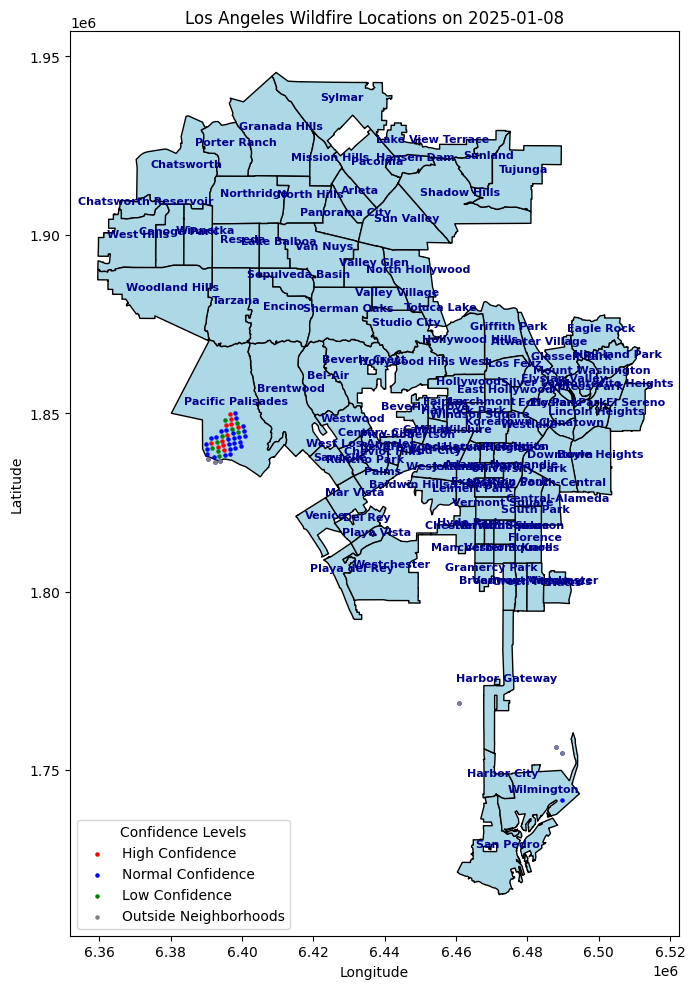

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# Baca data shapefile Los Angeles neighborhoods
shapefile_path = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"
neighborhoods_gdf = gpd.read_file(shapefile_path)

# Pastikan CRS untuk data batas wilayah sudah benar
print("Neighborhoods CRS:", neighborhoods_gdf.crs)

# =====================
# Baca data titik kebakaran (fire data)
fire_data = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")

# Pastikan kolom 'acq_date' adalah tipe datetime
fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date'])

# =====================
# Filter data berdasarkan tanggal tertentu (misalnya 2025-01-08)
date_filter = '2025-01-07'
fire_data_filtered = fire_data[fire_data['acq_date'] == date_filter]

# Filter data berdasarkan wilayah Los Angeles (latitude dan longitude)
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
fire_data_filtered = fire_data_filtered[
    (fire_data_filtered['latitude'] >= lat_min) & 
    (fire_data_filtered['latitude'] <= lat_max) & 
    (fire_data_filtered['longitude'] >= lon_min) & 
    (fire_data_filtered['longitude'] <= lon_max)
]

# =====================
# Ubah data titik kebakaran menjadi GeoDataFrame
fire_gdf = gpd.GeoDataFrame(fire_data_filtered, 
                            geometry=gpd.points_from_xy(fire_data_filtered.longitude, fire_data_filtered.latitude))

# Tentukan CRS untuk data titik kebakaran (lat/lon -> EPSG:4326)
fire_gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

# =====================
# Proyeksikan data titik kebakaran ke CRS yang sama dengan batas wilayah (EPSG:2229)
fire_gdf = fire_gdf.to_crs(neighborhoods_gdf.crs)

# =====================
# Lakukan spatial join antara titik kebakaran dan batas wilayah dengan predicate="within"
fire_with_names = gpd.sjoin(fire_gdf, neighborhoods_gdf, how="left", predicate="within")

# =====================
# Ganti nilai NaN di kolom 'name' dengan 'Else' (untuk titik yang di luar wilayah)
fire_with_names['name'].fillna('Else', inplace=True)

# =====================
# Hitung jumlah titik api berdasarkan confidence level
counts = fire_with_names.groupby(['name', 'confidence']).size().reset_index(name='count')
pivot_df = counts.pivot(index='name', columns='confidence', values='count').fillna(0)

# Tampilkan hasil jumlah titik api berdasarkan confidence
print(pivot_df)
print(fire_gdf.head())
# =====================
# Visualisasi Peta
fig, ax = plt.subplots(figsize=(10, 10))

# Plotkan batas wilayah
neighborhoods_gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# Plotkan titik kebakaran dengan warna berdasarkan confidence
fire_with_names[fire_with_names['confidence'] == 'h'].plot(ax=ax, color='red', markersize=5, label='High Confidence')
fire_with_names[fire_with_names['confidence'] == 'n'].plot(ax=ax, color='blue', markersize=5, label='Normal Confidence')
fire_with_names[fire_with_names['confidence'] == 'l'].plot(ax=ax, color='green', markersize=5, label='Low Confidence')

# Plotkan titik yang di luar wilayah dengan kategori "Else"
fire_with_names[fire_with_names['name'] == 'Else'].plot(ax=ax, color='gray', markersize=5, label='Outside Neighborhoods')

# Tambahkan nama wilayah pada peta
for idx, row in neighborhoods_gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(
        row['name'],  # Nama wilayah
        xy=(centroid.x, centroid.y),  # Koordinat centroid
        xytext=(5, 5),  # Offset teks
        textcoords='offset points',  # Menggunakan offset dalam poin
        fontsize=8,  # Ukuran font
        color='darkblue',  # Warna teks
        fontweight='bold',  # Tebalkan font
        ha='center',  # Horizontal alignment
        va='center'  # Vertical alignment
    )

# Tambahkan judul, legenda dan atur tampilan grafik
plt.title('Los Angeles Wildfire Locations on 2025-01-08')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Confidence Levels')

plt.tight_layout()

# Tampilkan grafik
plt.show()


In [269]:
import geopandas as gpd

shapefile_path = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"

try:
    neighborhoods_gdf = gpd.read_file(shapefile_path)
    print("Shapefile berhasil dibaca!")
    print(neighborhoods_gdf.head())  # Menampilkan beberapa baris pertama dari data
except Exception as e:
    print(f"Terjadi kesalahan: {e}")


Shapefile berhasil dibaca!
   OBJECTID                    name  \
0         1         Adams-Normandie   
1         2                  Arleta   
2         3       Arlington Heights   
3         4         Atwater Village   
4         5  Baldwin Hills/Crenshaw   

                                            geometry  
0  POLYGON ((6470572.729 1836095.881, 6469603.727...  
1  POLYGON ((6427957.726 1918793.756, 6428001.136...  
2  POLYGON ((6465156.612 1841842.871, 6465730.293...  
3  MULTIPOLYGON (((6477303.507 1878253.063, 64773...  
4  POLYGON ((6452277.375 1831789.765, 6452507.561...  


In [270]:
#Line Chart

In [271]:
import geopandas as gpd

shapefile_path = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"

try:
    neighborhoods_gdf = gpd.read_file(shapefile_path)
    print("Shapefile berhasil dibaca!")
    print(neighborhoods_gdf.head())  # Menampilkan beberapa baris pertama dari data
except Exception as e:
    print(f"Terjadi kesalahan: {e}")


Shapefile berhasil dibaca!
   OBJECTID                    name  \
0         1         Adams-Normandie   
1         2                  Arleta   
2         3       Arlington Heights   
3         4         Atwater Village   
4         5  Baldwin Hills/Crenshaw   

                                            geometry  
0  POLYGON ((6470572.729 1836095.881, 6469603.727...  
1  POLYGON ((6427957.726 1918793.756, 6428001.136...  
2  POLYGON ((6465156.612 1841842.871, 6465730.293...  
3  MULTIPOLYGON (((6477303.507 1878253.063, 64773...  
4  POLYGON ((6452277.375 1831789.765, 6452507.561...  


  acq_time  High  Normal  Low
0    09:02   102     472    0
1    10:42    41     289    0
2    20:21     9      80    5
3    22:01    22      39    9


C:\Users\SMART PC\AppData\Local\Temp\ipykernel_13512\3553847054.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  based_date['acq_time'] = based_date['acq_time'].str.zfill(4).str[:2] + ':' + based_date['acq_time'].str.zfill(4).str[2:]
C:\Users\SMART PC\AppData\Local\Temp\ipykernel_13512\3553847054.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  based_date['High'] = based_date['confidence'].apply(lambda x: 1 if x == 'h' else 0)
C:\Users\SMART PC\AppData\Local\Temp\ipykernel_13512\3553847054.py:38: Se

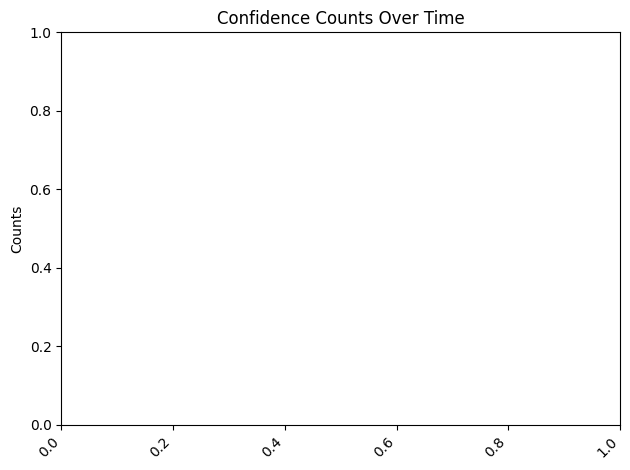

In [345]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point

# Import data wildfire
df = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")

# Filter lokasi (Los Angeles)
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
df = df[
    (df['latitude'] >= lat_min) &
    (df['latitude'] <= lat_max) &
    (df['longitude'] >= lon_min) &
    (df['longitude'] <= lon_max)
]

# Konversi tanggal dan waktu
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['acq_time'] = df['acq_time'].astype(str)
df['date_time'] = pd.to_datetime(
    df['acq_date'].dt.strftime('%Y-%m-%d') + ' ' +
    df['acq_time'].str.zfill(4).str[:2] + ':' + df['acq_time'].str.zfill(4).str[2:]
)
sorted_df = df.sort_values('date_time', ascending=True)

# Filter data berdasarkan tanggal tertentu
based_date = df[df['acq_date'] == pd.Timestamp(2025, 1, 8)]


# Pastikan acq_time adalah tipe datetime atau string yang benar
based_date['acq_time'] = based_date['acq_time'].str.zfill(4).str[:2] + ':' + based_date['acq_time'].str.zfill(4).str[2:]

# Menambahkan kolom High, Normal, Low berdasarkan confidence
based_date['High'] = based_date['confidence'].apply(lambda x: 1 if x == 'h' else 0)
based_date['Normal'] = based_date['confidence'].apply(lambda x: 1 if x == 'n' else 0)
based_date['Low'] = based_date['confidence'].apply(lambda x: 1 if x == 'l' else 0)

# Group by acq_time dan hitung jumlah untuk High, Normal, Low
based_date = based_date.groupby('acq_time').agg({'High': 'sum', 'Normal': 'sum', 'Low': 'sum'}).reset_index().fillna("Unknown")

# Menampilkan hasil groupby
print(based_date[['acq_time','High','Normal','Low']])

# Plotting data
#ax = based_date.plot(x='acq_time', y=['High', 'Normal','Low'])
#plt.xlabel('Acquisition Time')
plt.ylabel('Counts')
plt.title('Confidence Counts Over Time')

# Menampilkan semua label waktu di sumbu x
plt.xticks(rotation=45, ha='right')  # Rotasi label agar lebih mudah dibaca

plt.tight_layout()  # Untuk memastikan layout grafik tidak tumpang tindih
plt.show()

Neighborhoods CRS: EPSG:2229


C:\Users\SMART PC\AppData\Local\Temp\ipykernel_13512\2725567823.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_with_names['name'].fillna('Else', inplace=True)


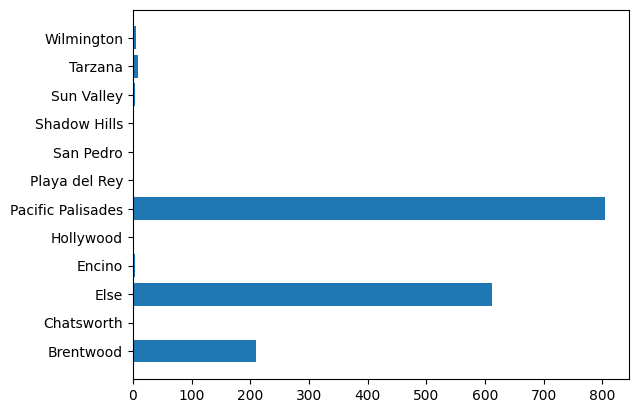

                 name  confidence
0           Brentwood         210
1          Chatsworth           2
2                Else         612
3              Encino           3
4           Hollywood           1
5   Pacific Palisades         805
6       Playa del Rey           1
7           San Pedro           1
8        Shadow Hills           1
9          Sun Valley           4
10            Tarzana           8
11         Wilmington           5


In [351]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# Baca data shapefile Los Angeles neighborhoods
shapefile_path = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"
neighborhoods_gdf = gpd.read_file(shapefile_path)

# Pastikan CRS untuk data batas wilayah sudah benar
print("Neighborhoods CRS:", neighborhoods_gdf.crs)

# =====================
# Baca data titik kebakaran (fire data)
fire_data = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")

# Pastikan kolom 'acq_date' adalah tipe datetime
fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date'])

# =====================
# Filter data berdasarkan tanggal tertentu (misalnya 2025-01-08)
#date_filter = '2025-01-07'
#fire_data_filtered = fire_data[fire_data['acq_date'] == date_filter]

# Filter data berdasarkan wilayah Los Angeles (latitude dan longitude)
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
fire_data = fire_data[
    (fire_data['latitude'] >= lat_min) & 
    (fire_data['latitude'] <= lat_max) & 
    (fire_data['longitude'] >= lon_min) & 
    (fire_data['longitude'] <= lon_max)
]

# =====================
# Ubah data titik kebakaran menjadi GeoDataFrame
fire_gdf = gpd.GeoDataFrame(fire_data, 
                            geometry=gpd.points_from_xy(fire_data.longitude, fire_data.latitude))

# Tentukan CRS untuk data titik kebakaran (lat/lon -> EPSG:4326)
fire_gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

# =====================
# Proyeksikan data titik kebakaran ke CRS yang sama dengan batas wilayah (EPSG:2229)
fire_gdf = fire_gdf.to_crs(neighborhoods_gdf.crs)

# =====================
# Lakukan spatial join antara titik kebakaran dan batas wilayah dengan predicate="within"
fire_with_names = gpd.sjoin(fire_gdf, neighborhoods_gdf, how="left", predicate="within")

# =====================
# Ganti nilai NaN di kolom 'name' dengan 'Else' (untuk titik yang di luar wilayah)
fire_with_names['name'].fillna('Else', inplace=True)

# =====================
# Hitung jumlah titik api berdasarkan confidence level
#counts = fire_with_names.groupby(['name', 'confidence']).size().reset_index(name='count')
#pivot_df = counts.pivot(index='name', columns='confidence', values='count').fillna(0)
dist_group = fire_with_names.groupby('name').agg({'confidence':'count'})
dist_group = dist_group.reset_index()

# Tampilkan hasil jumlah titik api berdasarkan confidence

plt.barh(dist_group['name'], dist_group['confidence'])
plt.show()

print(dist_group)



In [356]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Baca file CSV
data = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_Los_Angeles.csv")

# Fungsi untuk geocoding menggunakan Nominatim
def get_location_nominatim(lat, lon):
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={lat}&lon={lon}&addressdetails=1"
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    if response.status_code == 200:
        location = response.json()
        return location.get('address', {}).get('county', 'Unknown')
    return 'Error'

# Fungsi untuk memproses data dengan paralel
def process_geocoding(row):
    return get_location_nominatim(row['latitude'], row['longitude'])

# Menggunakan ThreadPoolExecutor untuk pemrosesan paralel
with ThreadPoolExecutor(max_workers=5) as executor:
    locations = list(executor.map(process_geocoding, [row for _, row in data.iterrows()]))

# Tambahkan kolom lokasi berdasarkan koordinat
data['Location'] = locations

# Simpan hasil ke file baru
data.to_csv('fire_points_with_location.csv', index=False)


KeyboardInterrupt: 

In [2]:
#  cari total cofidence level keseluruhan data

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# Baca data shapefile Los Angeles neighborhoods
shapefile_path = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"
neighborhoods_gdf = gpd.read_file(shapefile_path)

# Pastikan CRS untuk data batas wilayah sudah benar
print("Neighborhoods CRS:", neighborhoods_gdf.crs)

# =====================
# Baca data titik kebakaran (fire data)
fire_data = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")

# Pastikan kolom 'acq_date' adalah tipe datetime
fire_data['acq_date'] = pd.to_datetime(fire_data['acq_date'])


# Filter data berdasarkan wilayah Los Angeles (latitude dan longitude)
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
fire_data = fire_data[
    (fire_data['latitude'] >= lat_min) & 
    (fire_data['latitude'] <= lat_max) & 
    (fire_data['longitude'] >= lon_min) & 
    (fire_data['longitude'] <= lon_max)
]

# =====================
# Ubah data titik kebakaran menjadi GeoDataFrame
fire_gdf = gpd.GeoDataFrame(fire_data, 
                            geometry=gpd.points_from_xy(fire_data.longitude, fire_data.latitude))

# Tentukan CRS untuk data titik kebakaran (lat/lon -> EPSG:4326)
fire_gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

# =====================
# Proyeksikan data titik kebakaran ke CRS yang sama dengan batas wilayah (EPSG:2229)
fire_gdf = fire_gdf.to_crs(neighborhoods_gdf.crs)

# =====================
# Lakukan spatial join antara titik kebakaran dan batas wilayah dengan predicate="within"
fire_with_names = gpd.sjoin(fire_gdf, neighborhoods_gdf, how="left", predicate="within")

# =====================
# Ganti nilai NaN di kolom 'name' dengan 'Else' (untuk titik yang di luar wilayah)
fire_with_names['name'].fillna('Else', inplace=True)


confidenceTotal = fire_with_names.agg({'confidence':'count'})

print(confidenceTotal)


Neighborhoods CRS: EPSG:2229
confidence    1653
dtype: int64


C:\Users\SMART PC\AppData\Local\Temp\ipykernel_6312\2472341268.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_with_names['name'].fillna('Else', inplace=True)


In [3]:
import pandas as pd
import geopandas as gpd
import folium

# Load data titik api
df = pd.read_csv(r"E:\Practice Data Science\DL_FIRE_J2V-C2_566187\fire_nrt_J2V-C2_566187.csv")
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Load shapefile batas wilayah daratan
shapefile_daratan = r"E:\datascienceanalyst\Los Angeles\County_Boundary\County_Boundary.shp"
daratan_gdf = gpd.read_file(shapefile_daratan).to_crs("EPSG:4326")

# Load shapefile neighborhood
shapefile_neighborhoods = r"E:\Practice Data Science\LA_Times_Neighborhood_Boundaries-shp\8494cd42-db48-4af1-a215-a2c8f61e96a22020328-1-621do0.x5yiu.shp"
neighborhoods_gdf = gpd.read_file(shapefile_neighborhoods).to_crs("EPSG:4326")

# Filter titik api hanya di Los Angeles berdasarkan koordinat
lat_min, lat_max = 33.7, 34.3
lon_min, lon_max = -118.7, -118.2
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) & 
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Konversi dataframe titik api ke GeoDataFrame
fire_gdf = gpd.GeoDataFrame(df, 
                            geometry=gpd.points_from_xy(df.longitude, df.latitude),
                            crs="EPSG:4326")

# Lakukan spatial join untuk hanya mengambil titik api di daratan
fire_daratan = gpd.sjoin(fire_gdf, daratan_gdf, how="inner", predicate="within")

# Lakukan spatial join dengan neighborhood untuk menambahkan informasi lokasi
fire_daratan = gpd.sjoin(fire_daratan, neighborhoods_gdf, how="left", predicate="within", rsuffix="_neigh")

# Tentukan tanggal yang diinginkan
target_date = pd.to_datetime("2025-02-07").date()

# Ambil hanya data dengan tanggal 7 Februari 2025
fire_daratan = fire_daratan[fire_daratan['acq_date'].dt.date == target_date]

print(f"Total titik api di Los Angeles pada {target_date}: {len(fire_daratan)}")

# Buat peta
fire_map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Tambahkan titik api ke peta dengan neighborhood
for _, row in fire_daratan.iterrows():
    color = '#801100' if row['confidence'] == 'h' else '#D73502' if row['confidence'] == 'n' else '#FC6400'
    neighborhood = row['name'] if 'name' in row else "Unknown"
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        popup=f"Neighborhood: {neighborhood}\nConfidence: {row['confidence']}"
    ).add_to(fire_map)

# Hitung total titik api
total_titik_api = len(fire_daratan)
print(f"Total titik api di Los Angeles pada {latest_date.date()}: {total_titik_api}")

# Tampilkan peta
fire_map


Total titik api di Los Angeles pada 2025-02-07: 0
Total titik api di Los Angeles pada 2025-01-15: 0


Index(['OBJECTID', 'CITY', 'CITY_ID', 'CITY_TYPE', 'CITY_NAME', 'CITY_LABEL',
       'COLOR_CODE', 'ABBR', 'CITY_NO', 'DESCRIPTN', 'URL', 'PHONE',
       'OF_AREA_SM', 'FEAT_TYPE', 'COMMENT', 'SUB_TYPE', 'COLOR', 'geometry'],
      dtype='object')
   OBJECTID  CITY  CITY_ID       CITY_TYPE       CITY_NAME      CITY_LABEL  \
0         1   250       31  Unincorporated  Unincorporated  Unincorporated   
1         2   250       31  Unincorporated  Unincorporated  Unincorporated   
2         3   250       31  Unincorporated  Unincorporated  Unincorporated   
3         4   250       31  Unincorporated  Unincorporated  Unincorporated   
4         5   250       31  Unincorporated  Unincorporated  Unincorporated   

   COLOR_CODE  ABBR  CITY_NO DESCRIPTN               URL       PHONE  \
0           1  UNIN        0     UNINC  www.lacounty.gov  2139744321   
1           1  UNIN        0     UNINC  www.lacounty.gov  2139744321   
2           1  UNIN        0     UNINC  www.lacounty.gov  213974432